In [35]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from cnn_model import Model
from sklearn.metrics import roc_auc_score
import datetime
import matplotlib.pyplot as plt

In [36]:
torch.cuda.is_available()
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

In [37]:
# 数据载入与处理
fea_col=np.load("data/fea_col.npy",allow_pickle=True)
train=pd.read_csv('data/train_set.csv')
test=pd.read_csv('data/val_set.csv')
train=(train.drop(columns='Label').values,train['Label'].values)
test=(test.drop(columns='Label').values,test['Label'].values)
train_set=TensorDataset(torch.tensor(train[0]).float(),torch.tensor(train[1]).float())
test_set=TensorDataset(torch.tensor(test[0]).float(),torch.tensor(test[1]).float())

In [38]:
# 超参数
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
batch_size=256
epochs=10
lr_rate=0.01
label_leaking_rate=0.1

In [39]:
# dataloader
trainloader=DataLoader(train_set,batch_size=batch_size,shuffle=True)
testloader =DataLoader(test_set ,batch_size=batch_size,shuffle=True)
# Model loader
M=Model(fea_col,gpu=torch.cuda.is_available())
try:
    M.load_state_dict("models/M.pth")
except:
    pass


In [40]:
# 训练的准备捏
history={'epoch':[],'loss':[],'test loss':[],'auc':[],'test auc':[]}
opt=torch.optim.Adam(M.parameters(),lr_rate,weight_decay=0.0001)
loss_func=nn.BCELoss()

In [41]:
time=lambda :datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('start time:{}'.format(time()))
for i in range(epochs):
    M.train()
    loss_sum=0.0
    auc_sum=0.0
    for step,(input,labels) in enumerate(trainloader,1):
        labels=torch.unsqueeze(labels,1)
        # 梯度清零
        opt.zero_grad()
        input,labels=input.cuda(),labels.cuda()
    
        # 正向传播
        output=M(input)
        loss=loss_func(output,labels)
        auc=roc_auc_score(labels.cpu().detach().numpy(),output.cpu().detach().numpy())
        # 反向传播
        loss.backward()
        opt.step()
    
        # 统计
        loss_sum+=loss.item()
        auc_sum+=auc.item()
    history['epoch'].append(i)
    history['loss'].append(loss_sum/step)
    history['auc'].append(auc_sum/step)
    # 验证阶段
    M.eval()
    test_loss_sum = 0.0
    test_auc_sum = 0.0
    for step,(input,labels) in enumerate(testloader,1):
        labels=torch.unsqueeze(labels,1)
        input,labels=input.cuda(),labels.cuda()
        # 正向传播
        output=M(input)
        loss=loss_func(output,labels)
        auc=roc_auc_score(labels.cpu().detach().numpy(),output.cpu().detach().numpy())

        # 统计
        test_loss_sum+=loss.item()
        test_auc_sum+=auc.item()
    history['test loss'].append(test_loss_sum/step)
    history['test auc'].append(test_auc_sum/step)
    # 打印日志
    print("Time : ",time())
    print("Epoch: ",i)
    print("Loss : ",history['loss'][i])
    print("AUC  : ",history['auc'][i])
    print("Test Loss : ",history['test loss'][i])
    print("Test AUC  : ",history['test auc'][i])
    print("")
    # 储存模型
    torch.save(M.state_dict(),"models/M.pth")


start time:2022-10-21 22:21:07
Time :  2022-10-21 22:21:37
Epoch:  0
Loss :  0.6138168702029809
AUC  :  0.7234996001018592
Test Loss :  0.6104630503058434
Test AUC  :  0.7310302946085169

Time :  2022-10-21 22:22:11
Epoch:  1
Loss :  0.6047048163161355
AUC  :  0.7346593173961747
Test Loss :  0.6048153126239777
Test AUC  :  0.732123285829944

Time :  2022-10-21 22:22:45
Epoch:  2
Loss :  0.6037241315216707
AUC  :  0.7358465442755662
Test Loss :  0.6054450350999833
Test AUC  :  0.7320415614509389

Time :  2022-10-21 22:23:19
Epoch:  3
Loss :  0.6034390630166223
AUC  :  0.7362467112467168
Test Loss :  0.6050870266556739
Test AUC  :  0.7317857032774756

Time :  2022-10-21 22:23:53
Epoch:  4
Loss :  0.6034147450196563
AUC  :  0.7360656971746435
Test Loss :  0.6082016757130623
Test AUC  :  0.731910707107402

Time :  2022-10-21 22:24:23
Epoch:  5
Loss :  0.6030027239401116
AUC  :  0.7364658975850839
Test Loss :  0.6061129230260849
Test AUC  :  0.7355798075846769

Time :  2022-10-21 22:24:48
E

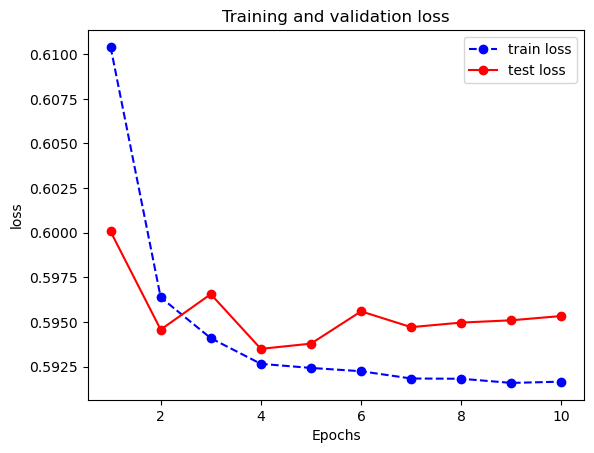

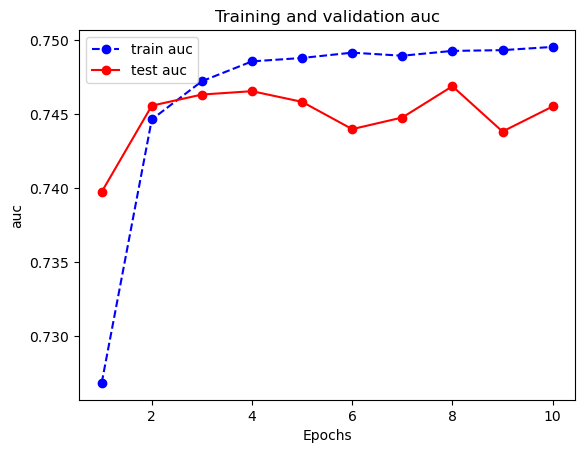

In [ ]:
def plot_(attri):
    train=history[attri]
    test= history['test '+attri]
    epochs=range(1, len(train) + 1)
    plt.plot(epochs,train, 'bo--')
    plt.plot(epochs,test , 'ro-')
    plt.title('Training and validation '+attri)
    plt.xlabel("Epochs")
    plt.ylabel(attri)
    plt.legend(["train "+attri, 'test '+attri])
    plt.show()
plot_('loss')
plot_('auc')